# Explore here

In [349]:
#!pip install hdbscan

In [350]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
from sklearn.impute import KNNImputer
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from lazypredict.Supervised import LazyRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.ensemble import BaggingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import joblib
import requests
from sklearn.linear_model import LinearRegression

In [351]:

url = 'https://raw.githubusercontent.com/4GeeksAcademy/data-preprocessing-project-tutorial/main/AB_NYC_2019.csv'
response = requests.get(url, 'html.parser')

with open('C:/Users/Agustín/Desktop/4Geeks/Clases/14. EDA Machine Learning Algo/machine-learning-python-template/data/raw/datahtml.csv', mode='wb') as file:
    file.write(response.content)

In [352]:
df = pd.read_csv('C:/Users/Agustín/Desktop/4Geeks/Clases/14. EDA Machine Learning Algo/machine-learning-python-template/data/raw/datahtml.csv').iloc[:,1:]
pd.set_option('display.max_columns', None)
df.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.65,-73.97,Private room,149,1,9,2018-10-19,0.21,6,365
1,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75,-73.98,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.81,-73.94,Private room,150,3,0,NaN,NaN,1,365
3,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.69,-73.96,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.80,-73.94,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [353]:
df.tail()

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
48890,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.68,-73.95,Private room,70,2,0,NaN,NaN,2,9
48891,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70,-73.93,Private room,40,4,0,NaN,NaN,2,36
48892,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81,-73.95,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.76,-73.99,Shared room,55,1,0,NaN,NaN,6,2
48894,Trendy duplex in the very heart of Hell's Kitchen,68119814,Christophe,Manhattan,Hell's Kitchen,40.76,-73.99,Private room,90,7,0,NaN,NaN,1,23


In [354]:
print(df.shape)
df.info()

(48895, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            48879 non-null  object 
 1   host_id                         48895 non-null  int64  
 2   host_name                       48874 non-null  object 
 3   neighbourhood_group             48895 non-null  object 
 4   neighbourhood                   48895 non-null  object 
 5   latitude                        48895 non-null  float64
 6   longitude                       48895 non-null  float64
 7   room_type                       48895 non-null  object 
 8   price                           48895 non-null  int64  
 9   minimum_nights                  48895 non-null  int64  
 10  number_of_reviews               48895 non-null  int64  
 11  last_review                     38843 non-null  object 
 12  reviews_per_month   

In [355]:
unique_var = df.nunique()==1

if any(unique_var): 
    for col in unique_var.index[unique_var] : print(f"The variable {i} content only one category.")
else: print(f"There's no variable with only one category.")

There's no variable with only one category.


In [356]:
print(f'Number of duplicated values: {df.duplicated().sum()}') 
#df.drop("PassengerId", axis = 1).duplicated().sum() si tuvieramos que sacar alguna columna del analisis de los duplicados usamos el drop definiendo qué columnas
# tambien eliminaríamos los duplicados con "drop_duplicates()"

Number of duplicated values: 0


In [357]:
df_lastreviews = df['last_review'].dropna() # no sé porque no me elimina todos los 'Nan'
print(df['last_review'].head())

0    2018-10-19
1    2019-05-21
2           NaN
3    2019-07-05
4    2018-11-19
Name: last_review, dtype: object


The column "last_review" is a date type value, and we don't really know yet if we're gonna use it or not... \
we keep that variable included in the df by the moment, and further we'll decide wheter it suits for determine \
if it correlates with another variable

In [358]:
df.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.65,-73.97,Private room,149,1,9,2018-10-19,0.21,6,365
1,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75,-73.98,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.81,-73.94,Private room,150,3,0,NaN,NaN,1,365
3,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.69,-73.96,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.80,-73.94,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [359]:
df.drop(columns=['name','host_id','host_name'],inplace=True) #variables que no me sirven
df.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,48895.00,40.73,0.05,40.50,40.69,40.72,40.76,40.91
longitude,48895.00,-73.95,0.05,-74.24,-73.98,-73.96,-73.94,-73.71
price,48895.00,152.72,240.15,0.00,69.00,106.00,175.00,10000.00
minimum_nights,48895.00,7.03,20.51,1.00,1.00,3.00,5.00,1250.00
number_of_reviews,48895.00,23.27,44.55,0.00,1.00,5.00,24.00,629.00
reviews_per_month,38843.00,1.37,1.68,0.01,0.19,0.72,2.02,58.50
calculated_host_listings_count,48895.00,7.14,32.95,1.00,1.00,1.00,2.00,327.00
availability_365,48895.00,112.78,131.62,0.00,0.00,45.00,227.00,365.00


In [360]:
# verificar las prop valor CERO

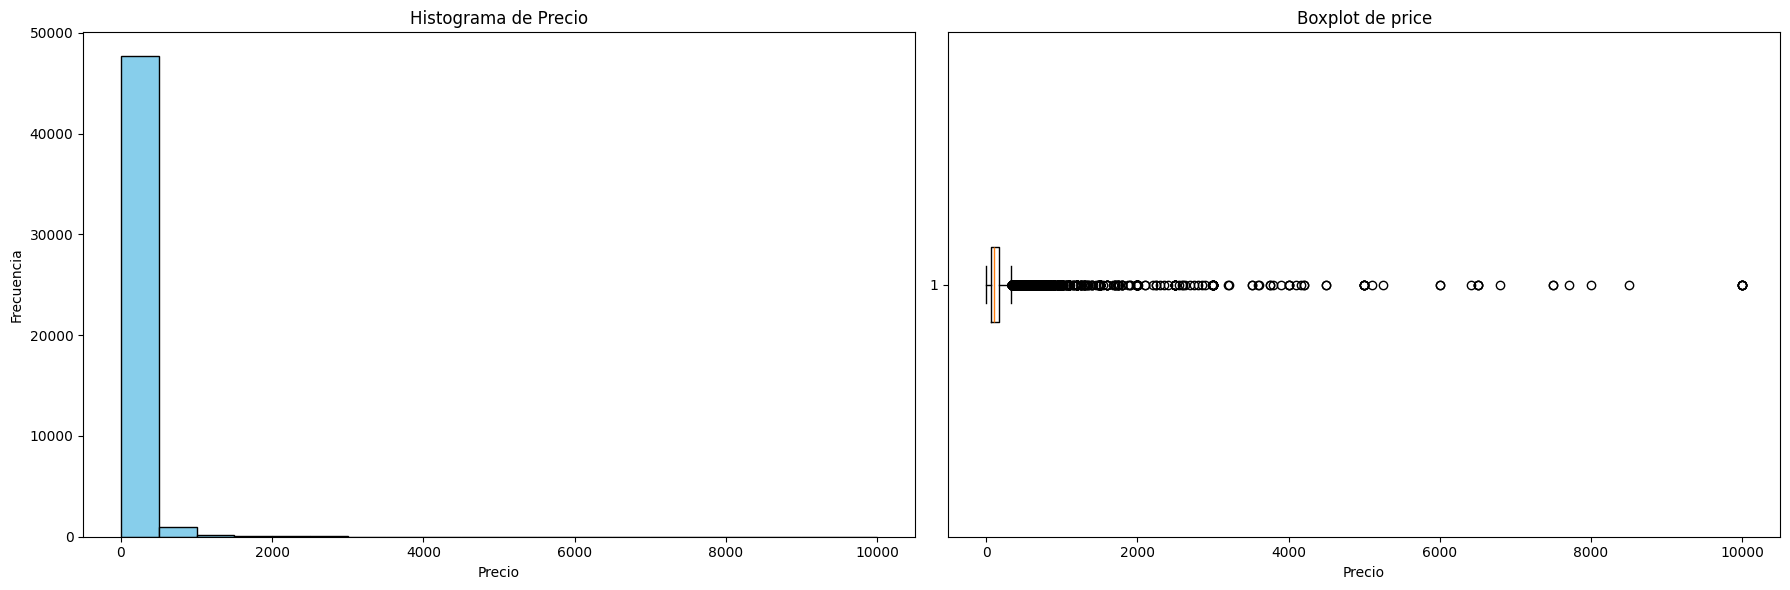

In [361]:
# Crear una figura con dos subplots (uno para el histograma y otro para el boxplot)
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Crear un histograma en el primer subplot
ax[0].hist(df['price'], bins=20, color='skyblue', edgecolor='black')
ax[0].set_title('Histograma de Precio')
ax[0].set_xlabel('Precio')
ax[0].set_ylabel('Frecuencia')

# Crear un boxplot en el segundo subplot
ax[1].boxplot(df['price'], vert=False)
ax[1].set_title('Boxplot de price')
ax[1].set_xlabel('Precio')

# Mostrar la figura
plt.tight_layout()
plt.show()

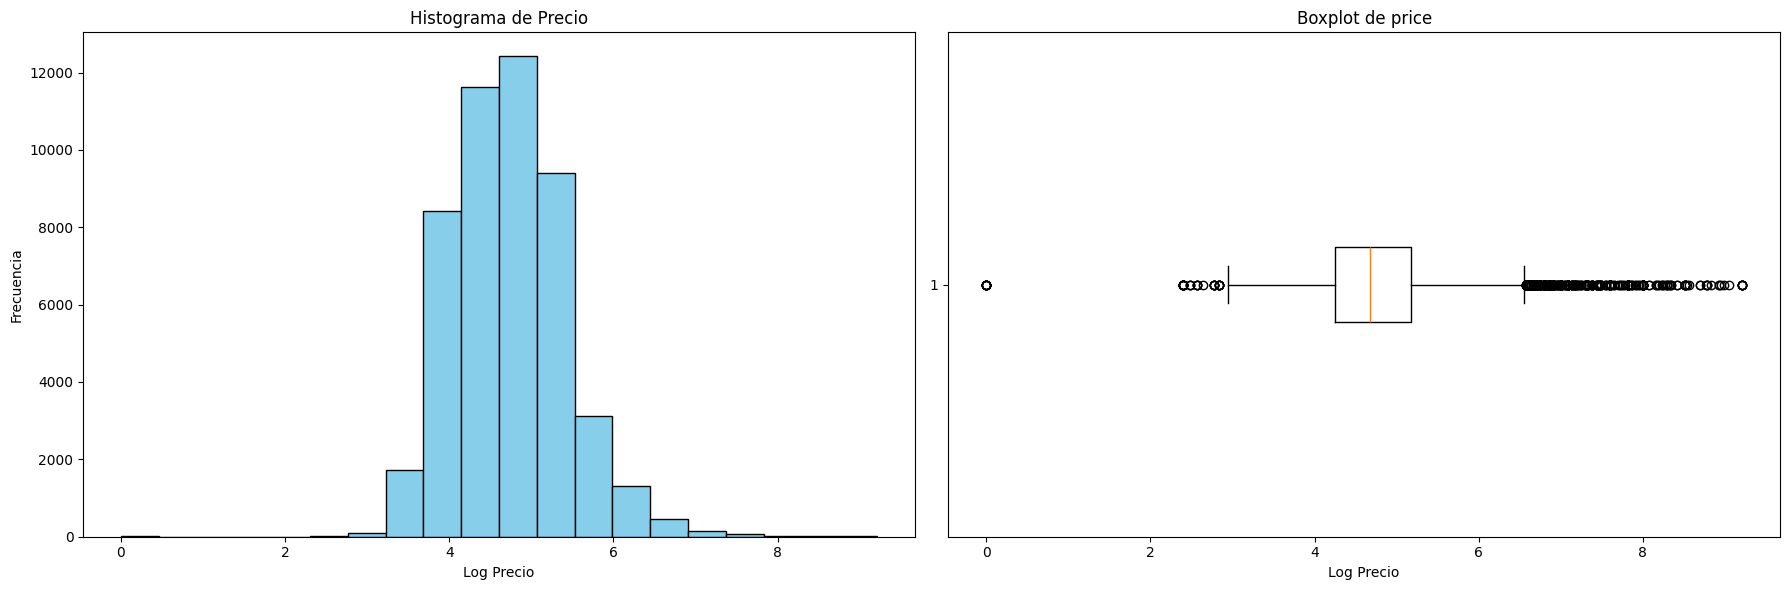

In [362]:
df['Log_Price'] = np.log(df.price+1)
# Crear una figura con dos subplots (uno para el histograma y otro para el boxplot)
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Crear un histograma en el primer subplot
ax[0].hist(df['Log_Price'], bins=20, color='skyblue', edgecolor='black')
ax[0].set_title('Histograma de Precio')
ax[0].set_xlabel('Log Precio')
ax[0].set_ylabel('Frecuencia')

# Crear un boxplot en el segundo subplot
ax[1].boxplot(df['Log_Price'], vert=False)
ax[1].set_title('Boxplot de price')
ax[1].set_xlabel('Log Precio')

# Mostrar la figura
plt.tight_layout()
plt.show()



In [363]:
print(df.isnull().sum())
df.isnull().mean()*100

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
Log_Price                             0
dtype: int64


neighbourhood_group               0.00
neighbourhood                     0.00
latitude                          0.00
longitude                         0.00
room_type                         0.00
price                             0.00
minimum_nights                    0.00
number_of_reviews                 0.00
last_review                      20.56
reviews_per_month                20.56
calculated_host_listings_count    0.00
availability_365                  0.00
Log_Price                         0.00
dtype: float64

In [364]:
df.drop(columns=['price'], inplace=True)
asd = df.isnull().any(axis=1).sum()/len(df)*100
print(f'The {asd:.2f}% of rows have at least one null value')

The 20.56% of rows have at least one null value


<Axes: >

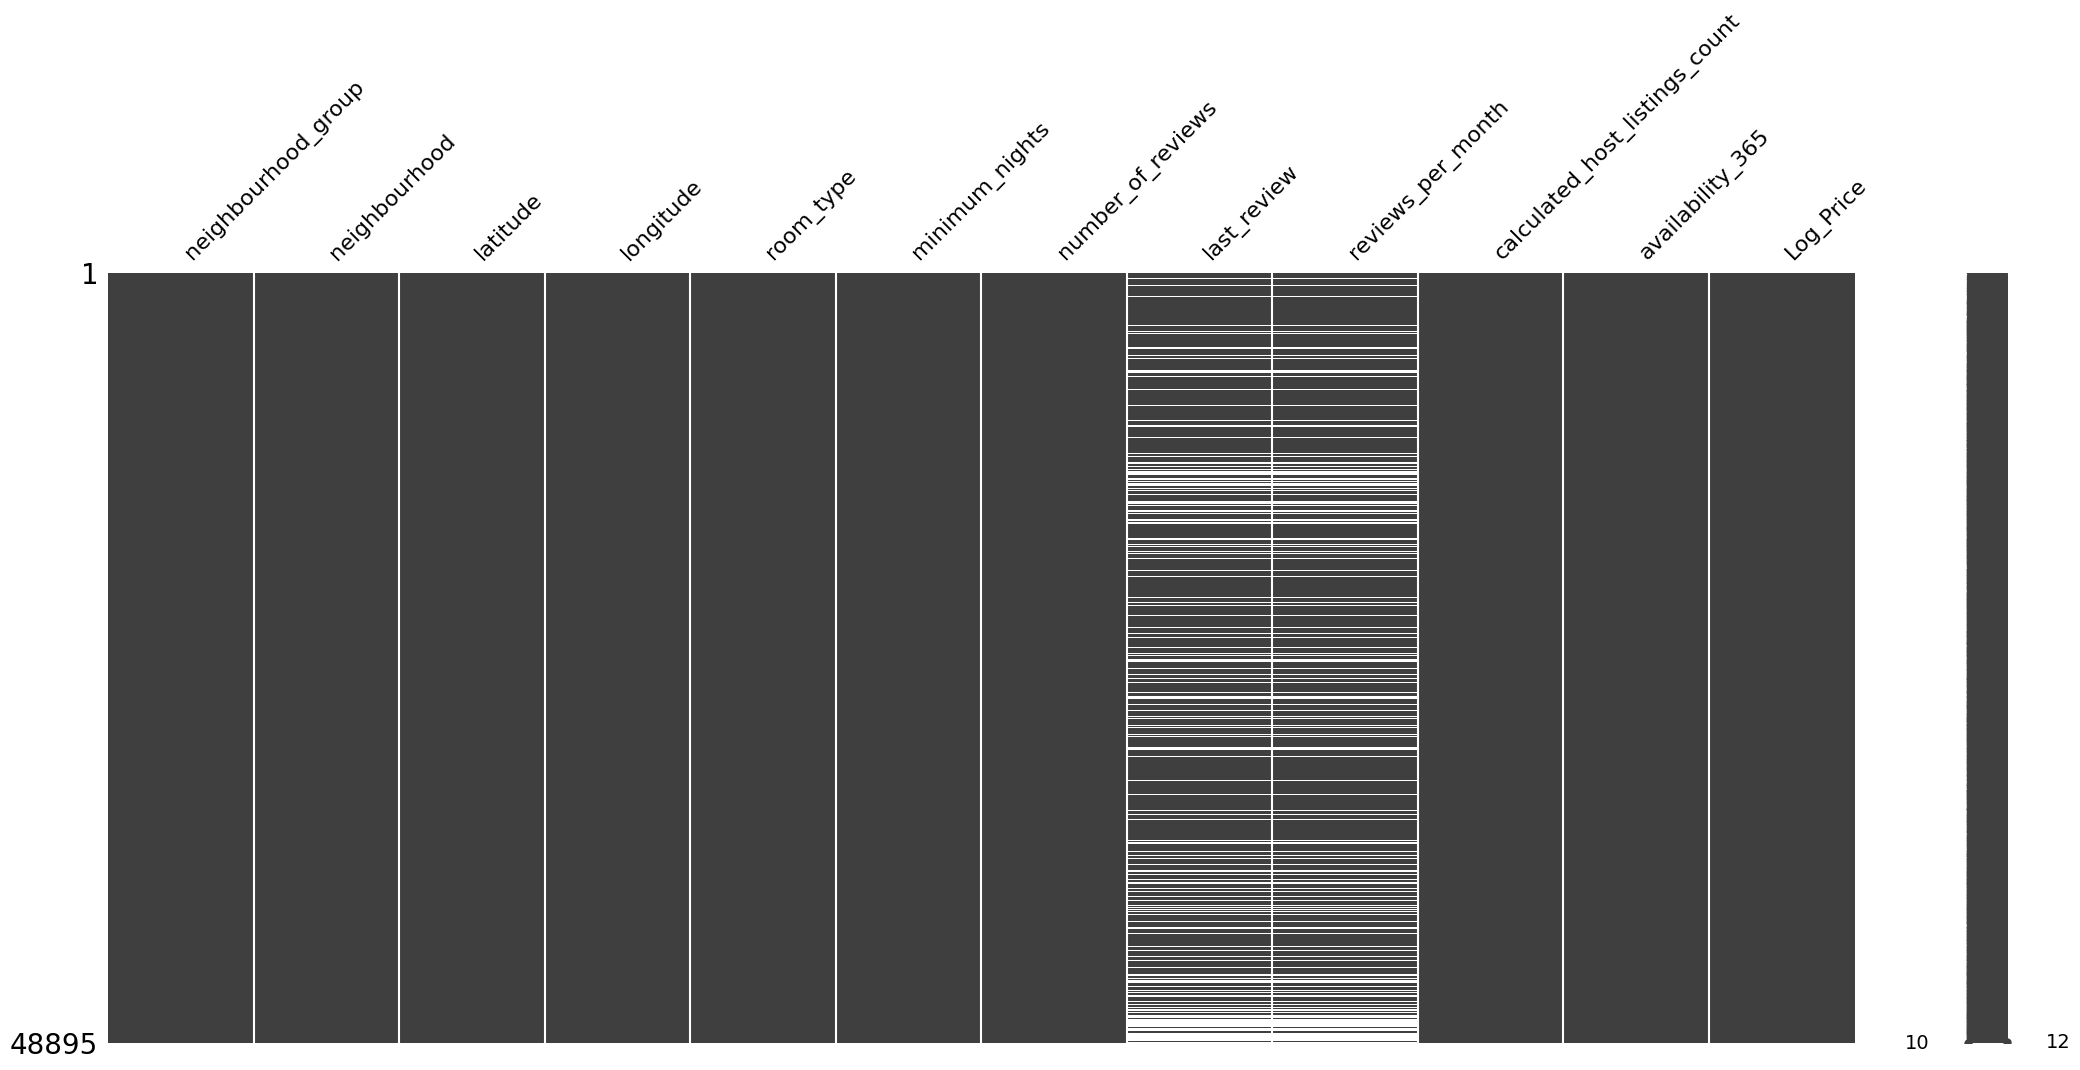

In [365]:
msno.matrix(df) # nos da un "mapa" donde podemos visualizar los valores null o faltantes del dataframe de manera visual

In [366]:
imputador_knn = KNNImputer(n_neighbors=5) #busca los "vecinos" más cercanos (en este caso, filas similares) para estimar los valores faltantes
#df[['last_review', 'reviews_per_month']] = imputador_knn.fit_transform(df[['last_review', 'reviews_per_month']])
imputador_knn

KNNImputer()

I don't think is convenient to fill the missing values in 'last_review' & 'reviews_per_month' because we might corrupt data \
probably needed for further analysis

In [367]:
# Asumiendo que los "Nan" en 'last_review" y en 'reviews_per_month' corresponden a propiedades nuevas o sin alquileres previos,
# generamos una columna nueva de "New_Prop" boleano

df['new_prop'] = (df['last_review'].isna() & df['reviews_per_month'].isna())
df.head(3)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,Log_Price,new_prop
0,Brooklyn,Kensington,40.65,-73.97,Private room,1,9,2018-10-19,0.21,6,365,5.01,False
1,Manhattan,Midtown,40.75,-73.98,Entire home/apt,1,45,2019-05-21,0.38,2,355,5.42,False
2,Manhattan,Harlem,40.81,-73.94,Private room,3,0,NaN,NaN,1,365,5.02,True


In [368]:
# elimino ambas columnas ya que no son "reviews" sino cuenta de reviews y fecha de ultima. Entiendo que no es determinante de variacion de precio
df.drop(['last_review','reviews_per_month'], axis=1, inplace=True)
df.head(3)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,Log_Price,new_prop
0,Brooklyn,Kensington,40.65,-73.97,Private room,1,9,6,365,5.01,False
1,Manhattan,Midtown,40.75,-73.98,Entire home/apt,1,45,2,355,5.42,False
2,Manhattan,Harlem,40.81,-73.94,Private room,3,0,1,365,5.02,True


In [369]:
df.dtypes

neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
minimum_nights                      int64
number_of_reviews                   int64
calculated_host_listings_count      int64
availability_365                    int64
Log_Price                         float64
new_prop                             bool
dtype: object

In [370]:
#para ver cuantas variables dummies deberiamos incluir en el dataframe
print(f'Number of neighbourhood_group variables: {df.neighbourhood_group.nunique()}') 
print(f'Number of neighbourhood variables: {df.neighbourhood.nunique()}')
print(f'Number of room_type variables: {df.room_type.nunique()}')

Number of neighbourhood_group variables: 5
Number of neighbourhood variables: 221
Number of room_type variables: 3


Due to the amout of categories in both variables, we can conclude that is unconvenient to set dummies variables \
for "neighbourhood" categories, but we'll do it for "neighbourhood_group" and "room_type".

In [371]:
df_with_dummies = pd.get_dummies(df, columns=['neighbourhood_group','room_type'],drop_first=False) # creamos las dummies de 'neighbourhood_group' y 'room_type'
#df_with_dummies = df_with_dummies.astype(int) 
df_with_dummies.head()

,neighbourhood,latitude,longitude,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,Log_Price,new_prop,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,Kensington,40.65,-73.97,1,9,6,365,5.01,False,False,True,False,False,False,False,True,False
1,Midtown,40.75,-73.98,1,45,2,355,5.42,False,False,False,True,False,False,True,False,False
2,Harlem,40.81,-73.94,3,0,1,365,5.02,True,False,False,True,False,False,False,True,False
3,Clinton Hill,40.69,-73.96,1,270,1,194,4.50,False,False,True,False,False,False,True,False,False
4,East Harlem,40.80,-73.94,10,9,1,0,4.39,False,False,False,True,False,False,True,False,False


In [372]:
#reemplazo cada categ de 'neighbourhood' por su frecuencia de ocurrencia dentro de la lista
freq = df_with_dummies['neighbourhood'].value_counts()
df_with_dummies['neighbourhood_encoded'] = df_with_dummies['neighbourhood'].map(freq)
df_with_dummies.head()

,neighbourhood,latitude,longitude,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,Log_Price,new_prop,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,neighbourhood_encoded
0,Kensington,40.65,-73.97,1,9,6,365,5.01,False,False,True,False,False,False,False,True,False,175
1,Midtown,40.75,-73.98,1,45,2,355,5.42,False,False,False,True,False,False,True,False,False,1545
2,Harlem,40.81,-73.94,3,0,1,365,5.02,True,False,False,True,False,False,False,True,False,2658
3,Clinton Hill,40.69,-73.96,1,270,1,194,4.50,False,False,True,False,False,False,True,False,False,572
4,East Harlem,40.80,-73.94,10,9,1,0,4.39,False,False,False,True,False,False,True,False,False,1117


In [373]:
X = df_with_dummies.drop(['Log_Price','neighbourhood'], axis=1)
X = X.astype(int) # tuve que hacer esto porque los bool no los toma como 0 y 1
y = df_with_dummies.Log_Price


# Ajusta el modelo
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Instancia de la influencia y obtención de la distancia de cook para cada observación
cooks_distance = model.get_influence().cooks_distance

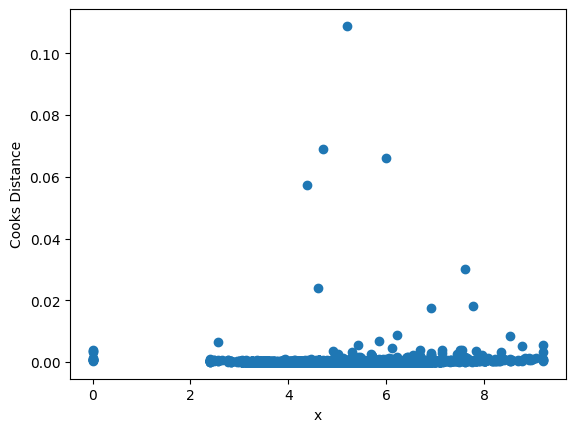

In [374]:
plt.scatter(df_with_dummies.Log_Price, cooks_distance[0])
plt.xlabel('x')
plt.ylabel('Cooks Distance')
plt.show()

In [375]:
#quiero ver cuales son y si encuentro un patron por demas obvio
influent_rows = np.where(cooks_distance[0]>0.4) 
df_with_dummies.iloc[influent_rows]

,neighbourhood,latitude,longitude,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,Log_Price,new_prop,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,neighbourhood_encoded


In [376]:
df_with_dummies.iloc[influent_rows].T

""
neighbourhood
latitude
longitude
minimum_nights
number_of_reviews
calculated_host_listings_count
availability_365
Log_Price
new_prop
neighbourhood_group_Bronx


In [377]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [378]:
# Si la distancia es mayor de 4/n se considera observación influyente
pto_corte = 4/len(X)
pto_corte

8.180795582370386e-05

In [379]:
# Viviendas que se consideran observaciones influyentes
len(np.where(cooks_distance[0]>pto_corte)[0])/len(X)*100

3.6772676142754883

In [380]:
df_with_dummies.drop(np.where(cooks_distance[0]>pto_corte)[0], inplace=True)
df_with_dummies.shape

(47097, 18)

In [381]:
X = df_with_dummies.drop(['Log_Price','neighbourhood'], axis=1)
y = df_with_dummies.Log_Price

Vamos a seleccionar aleatoriamente un 80% del dataset para formar el conjunto de entrenamiento y un 20% para el conjunto de test.

In [382]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [383]:
# Usamos xgb para conocer la importancia de las características
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42).fit(X_train, y_train)
df_imp = pd.DataFrame({'Feature':X_train.columns, 'Importance':xgb_model.feature_importances_*100})
df_imp = df_imp.sort_values(by='Importance', ascending=False)
df_imp

,Feature,Importance
12,room_type_Entire home/apt,66.22
9,neighbourhood_group_Manhattan,24.35
13,room_type_Private room,3.11
7,neighbourhood_group_Bronx,1.12
1,longitude,0.98
0,latitude,0.82
2,minimum_nights,0.67
5,availability_365,0.52
8,neighbourhood_group_Brooklyn,0.45
15,neighbourhood_encoded,0.44


In [384]:
# Un buen punto de corte suele ser 1%, pero lo hago en 0.5% para incluir al menos 5 variables
df_imp[df_imp.Importance>=0.5].Feature.values

array(['room_type_Entire home/apt', 'neighbourhood_group_Manhattan',
       'room_type_Private room', 'neighbourhood_group_Bronx', 'longitude',
       'latitude', 'minimum_nights', 'availability_365'], dtype=object)

In [385]:
X_train = X_train[df_imp[df_imp.Importance>=0.5].Feature.values]
X_test = X_test[df_imp[df_imp.Importance>=0.5].Feature.values]
#X_train

In [386]:
'''
Obtenemos los valores de inflación de la varianza a partir de la matriz de correlaciones. 
Esto nos ayuda a identificar aquellas variables que presentan correlación con otras en nuestro dataset; 
esto es importante ya que debemos siempre que sea posible evitar la redundancia en los datos con el fin de 
mejorar la capacidad predictiva y de generalización de nuestros modelos. 
Un buen punto de corte para el vif suele ser 10. Un vif infinito implica una correlación perfecta.
'''
vif = pd.Series([variance_inflation_factor(X_train.corr().values, i) for i in range(X_train.corr().shape[1])], index=X_train.columns)
vif

room_type_Entire home/apt       885.81
neighbourhood_group_Manhattan    25.01
room_type_Private room          881.27
neighbourhood_group_Bronx         3.79
longitude                         6.69
latitude                         18.36
minimum_nights                    1.31
availability_365                  1.42
dtype: float64

In [387]:
X = df_with_dummies.drop(['Log_Price','neighbourhood','room_type_Private room'], axis=1)
y = df_with_dummies.Log_Price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42).fit(X_train, y_train)
df_imp = pd.DataFrame({'Feature':X_train.columns, 'Importance':xgb_model.feature_importances_*100})
df_imp = df_imp.sort_values(by='Importance', ascending=False)
df_imp

,Feature,Importance
12,room_type_Entire home/apt,54.31
9,neighbourhood_group_Manhattan,32.99
13,room_type_Shared room,4.81
7,neighbourhood_group_Bronx,1.67
1,longitude,1.22
0,latitude,1.02
2,minimum_nights,0.84
5,availability_365,0.70
14,neighbourhood_encoded,0.56
4,calculated_host_listings_count,0.53


In [388]:
# Un buen punto de corte suele ser 1%, pero lo hago en 0.5% para incluir al menos 5 variables
df_imp[df_imp.Importance>=0.5].Feature.values
X_train = X_train[df_imp[df_imp.Importance>=0.5].Feature.values]
X_test = X_test[df_imp[df_imp.Importance>=0.5].Feature.values]

vif = pd.Series([variance_inflation_factor(X_train.corr().values, i) for i in range(X_train.corr().shape[1])], index=X_train.columns)
vif

room_type_Entire home/apt         1.43
neighbourhood_group_Manhattan    30.46
room_type_Shared room             1.10
neighbourhood_group_Bronx         5.02
longitude                         7.44
latitude                         22.07
minimum_nights                    1.55
availability_365                  1.85
neighbourhood_encoded             1.99
calculated_host_listings_count    1.66
number_of_reviews                 1.32
dtype: float64

In [389]:
# matriz de correlaciones segun VIF
X_corr = X_train.copy()
X_corr['y'] = y_train
corr = X_corr.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

,room_type_Entire home/apt,neighbourhood_group_Manhattan,room_type_Shared room,neighbourhood_group_Bronx,longitude,latitude,minimum_nights,availability_365,neighbourhood_encoded,calculated_host_listings_count,number_of_reviews,y
room_type_Entire home/apt,1.000,0.160,-0.138,-0.053,-0.200,-0.004,0.114,-0.006,-0.055,0.109,-0.014,0.671
neighbourhood_group_Manhattan,0.160,1.000,-0.005,-0.126,-0.453,0.606,0.100,-0.008,-0.083,0.147,-0.047,0.366
room_type_Shared room,-0.138,-0.005,1.000,0.028,0.026,0.011,-0.013,0.048,-0.012,-0.009,-0.008,-0.174
neighbourhood_group_Bronx,-0.053,-0.126,0.028,1.000,0.210,0.312,-0.021,0.065,-0.169,-0.021,0.011,-0.118
longitude,-0.200,-0.453,0.026,0.210,1.000,0.043,-0.086,0.100,-0.046,-0.108,0.066,-0.361
latitude,-0.004,0.606,0.011,0.312,0.043,1.000,0.042,-0.004,0.020,0.028,-0.016,0.085
minimum_nights,0.114,0.100,-0.013,-0.021,-0.086,0.042,1.000,0.195,-0.008,0.225,-0.117,0.032
availability_365,-0.006,-0.008,0.048,0.065,0.100,-0.004,0.195,1.000,-0.082,0.228,0.184,0.087
neighbourhood_encoded,-0.055,-0.083,-0.012,-0.169,-0.046,0.020,-0.008,-0.082,1.000,-0.065,0.004,-0.025
calculated_host_listings_count,0.109,0.147,-0.009,-0.021,-0.108,0.028,0.225,0.228,-0.065,1.000,-0.071,0.136


We can see there's a correlation between 'neighbourhood_group_Queens' & 'longitude' variables, obviously due to the location of the neighbourhood, \
so we will drop the latitude and longitude variables based on the fact that we already have geographic information in "neighbourhood_group" \
dummies variables

In [390]:
X_train.drop(['longitude', 'latitude'], axis=1, inplace=True)
X_test.drop(['longitude', 'latitude'], axis=1, inplace=True)
X_train

,room_type_Entire home/apt,neighbourhood_group_Manhattan,room_type_Shared room,neighbourhood_group_Bronx,minimum_nights,availability_365,neighbourhood_encoded,calculated_host_listings_count,number_of_reviews
6359,True,False,False,False,2,108,3714,2,214
8681,False,False,False,False,1,0,3920,1,0
46240,False,False,False,False,1,0,157,1,1
33645,True,True,False,False,1,0,911,1,3
40447,False,False,False,False,2,100,1115,1,3
...,...,...,...,...,...,...,...,...,...
11661,True,False,False,False,3,0,3920,1,12
46408,False,False,False,False,1,0,185,7,3
39425,False,True,False,False,2,180,2658,4,4
899,False,False,False,False,3,266,572,6,15


In [391]:
vif = pd.Series([variance_inflation_factor(X_train.corr().values, i) for i in range(X_train.corr().shape[1])], index=X_train.columns)
vif

room_type_Entire home/apt        1.29
neighbourhood_group_Manhattan    1.33
room_type_Shared room            1.10
neighbourhood_group_Bronx        1.24
minimum_nights                   1.53
availability_365                 1.73
neighbourhood_encoded            1.22
calculated_host_listings_count   1.61
number_of_reviews                1.32
dtype: float64

In [392]:
# matriz de correlaciones segun VIF
X_corr = X_train.copy()
X_corr['y'] = y_train
corr = X_corr.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

,room_type_Entire home/apt,neighbourhood_group_Manhattan,room_type_Shared room,neighbourhood_group_Bronx,minimum_nights,availability_365,neighbourhood_encoded,calculated_host_listings_count,number_of_reviews,y
room_type_Entire home/apt,1.000,0.160,-0.138,-0.053,0.114,-0.006,-0.055,0.109,-0.014,0.671
neighbourhood_group_Manhattan,0.160,1.000,-0.005,-0.126,0.100,-0.008,-0.083,0.147,-0.047,0.366
room_type_Shared room,-0.138,-0.005,1.000,0.028,-0.013,0.048,-0.012,-0.009,-0.008,-0.174
neighbourhood_group_Bronx,-0.053,-0.126,0.028,1.000,-0.021,0.065,-0.169,-0.021,0.011,-0.118
minimum_nights,0.114,0.100,-0.013,-0.021,1.000,0.195,-0.008,0.225,-0.117,0.032
availability_365,-0.006,-0.008,0.048,0.065,0.195,1.000,-0.082,0.228,0.184,0.087
neighbourhood_encoded,-0.055,-0.083,-0.012,-0.169,-0.008,-0.082,1.000,-0.065,0.004,-0.025
calculated_host_listings_count,0.109,0.147,-0.009,-0.021,0.225,0.228,-0.065,1.000,-0.071,0.136
number_of_reviews,-0.014,-0.047,-0.008,0.011,-0.117,0.184,0.004,-0.071,1.000,-0.036
y,0.671,0.366,-0.174,-0.118,0.032,0.087,-0.025,0.136,-0.036,1.000


In [394]:
binary_cols = X_train[(X_train==0)|(X_train==1)].dropna(axis=1).columns.values
X_train.drop(binary_cols, axis=1).skew()

minimum_nights                   8.78
availability_365                 0.80
neighbourhood_encoded            0.64
calculated_host_listings_count   8.40
number_of_reviews                3.60
dtype: float64

<Axes: >

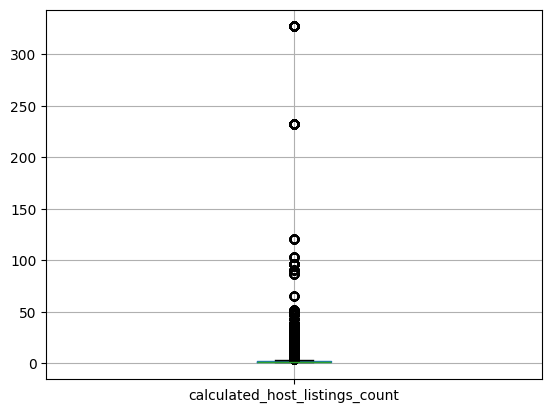

In [398]:
X_train.boxplot('calculated_host_listings_count')

In [400]:
# Escalamos las variables numéricas (no binarias) usando MinMaxScaler de modo que todas queden a una misma escala tomando valores entre 0 y 1. 
# Para el ajuste del escalador debe de tenerse en cuenta los datos de entrenamiento, después transformamos ambos conjuntos.

X_train_num = X_train.drop(binary_cols, axis=1)
X_test_num = X_test.drop(binary_cols, axis=1)

scaler = MinMaxScaler().fit(X_train_num)
X_train_num_sc = scaler.transform(X_train_num)
X_test_num_sc = scaler.transform(X_test_num) 

In [403]:
# unimos los datos escalados con los binarios

X_train_sc = pd.concat([pd.DataFrame(X_train_num_sc, columns=X_train_num.columns), X_train[binary_cols].reset_index(drop=True)], axis=1)
X_test_sc = pd.concat([pd.DataFrame(X_test_num_sc, columns=X_test_num.columns), X_test[binary_cols].reset_index(drop=True)], axis=1)
X_train_sc

,minimum_nights,availability_365,neighbourhood_encoded,calculated_host_listings_count,number_of_reviews,room_type_Entire home/apt,neighbourhood_group_Manhattan,room_type_Shared room,neighbourhood_group_Bronx
0,0.00,0.30,0.95,0.00,0.34,True,False,False,False
1,0.00,0.00,1.00,0.00,0.00,False,False,False,False
2,0.00,0.00,0.04,0.00,0.00,False,False,False,False
3,0.00,0.00,0.23,0.00,0.00,True,True,False,False
4,0.00,0.27,0.28,0.00,0.00,False,False,False,False
...,...,...,...,...,...,...,...,...,...
37672,0.01,0.00,1.00,0.00,0.02,True,False,False,False
37673,0.00,0.00,0.05,0.02,0.00,False,False,False,False
37674,0.00,0.49,0.68,0.01,0.01,False,True,False,False
37675,0.01,0.73,0.15,0.02,0.02,False,False,False,False


In [404]:
# Usamos la librería LazyPredict para realizar una comprativa de distintos modelos de regresión o 
# Clasificación con sus configuraciones por defecto. (cruzamos los dedos porque por esto terminé actualizando a python 3.12.5 en local)

regresor = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = regresor.fit(X_train_sc, X_test_sc, y_train, y_test)

 26%|██▌       | 11/42 [00:54<05:38, 10.93s/it]

GaussianProcessRegressor model failed to execute
Unable to allocate 5.29 GiB for an array with shape (709759326,) and data type float64


 36%|███▌      | 15/42 [01:00<01:35,  3.54s/it]

KernelRidge model failed to execute
Unable to allocate 10.6 GiB for an array with shape (37677, 37677) and data type float64


 74%|███████▍  | 31/42 [07:50<03:08, 17.14s/it]

QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.


 98%|█████████▊| 41/42 [10:35<00:16, 16.93s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 37677, number of used features: 5
[LightGBM] [Info] Start training from score 4.710101


100%|██████████| 42/42 [10:35<00:00, 15.14s/it]


In [405]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
XGBRegressor,0.40,0.40,0.49,1.25
LGBMRegressor,0.38,0.38,0.50,0.46
HistGradientBoostingRegressor,0.38,0.38,0.50,1.13
RandomForestRegressor,0.34,0.34,0.51,29.78
BaggingRegressor,0.30,0.30,0.53,3.14
GradientBoostingRegressor,0.30,0.30,0.53,3.50
ExtraTreesRegressor,0.30,0.30,0.53,17.04
MLPRegressor,0.21,0.21,0.56,22.56
NuSVR,0.17,0.17,0.57,157.54
